<a href="https://colab.research.google.com/github/csbozo/teste/blob/main/teste_previsao_brasileiro_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
#importar bibliotecas
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score , f1_score, precision_score, recall_score
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import  GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
%matplotlib inline

In [31]:
#lendo o arquivo BRAS.csv
#O arquivo utilizado foi baixado do site www.football-data.co.uk.

data=pd.read_csv('BRA.csv',delimiter=',')

#cria um data frame dimensão somente com os nome dos times
equipes = pd.DataFrame(data, columns=['Home'])

#ordenando os valores
equipes.sort_values('Home', inplace = True)

#elimina todos os valores duplicados
equipes = equipes.drop_duplicates(subset='Home', keep='first')

#cria coluna para identificação dos times
equipes.insert(0,'id_time',equipes.index,allow_duplicates=False)

#verifica o resultado do data frame de equipes
display(equipes.head())

#Verificando as 5 primeiras linhas do arquivo a ser utilizado
display(data.head())

display('===========')

#Metadados do csv de origem

#Country = país do campeonato
#League = nome da liga
#Season = temporada
#date = data do jogo
#Time = hora do jogo
#Home = Time da casa
#Away = time visitante
#HG = Gols do time da casa
#AG = Gols do time visitante
#Res = Resultado do jogo (D=Draw, H=Home win, A=Away win)
#PH = probablidade vitória time da casa provida pela Pinacle (casa de aposta inglesa)
#PD = probablidade empate provida pela Pinacle (casa de aposta inglesa)
#PA = probablidade vitória time visitante provida pela Pinacle (casa de aposta inglesa)
#MaxH = probablidade vitória time da casa provida pela OddsPortal (casa de aposta inglesa)
#MaxD = probablidade empate provida pela OddsPortal (casa de aposta inglesa)
#MaxA = probablidade vitória time visitante provida pela OddsPortal (casa de aposta ingles
#AvgH = probablidade média de vitória em casa provida pela OddsPortal (casa de aposta inglesa)
#AvgD = probablidade média de empate provida pela OddsPortal (casa de aposta inglesa)
#AvgA = probablidade média de vitória pelo time visitante provida pela OddsPortal (casa de aposta inglesa)

,id_time,Home
3434,3434,America MG
3115,3115,Athletico-PR
333,333,Atletico GO
2604,2604,Atletico-MG
2133,2133,Atletico-PR


,Country,League,Season,Date,Time,Home,Away,HG,AG,Res,PH,PD,PA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA
0,Brazil,Serie A,2012,19/05/2012,22:30,Palmeiras,Portuguesa,1.0,1.0,D,1.75,3.86,5.25,1.76,3.87,5.31,1.69,3.50,4.90
1,Brazil,Serie A,2012,19/05/2012,22:30,Sport Recife,Flamengo RJ,1.0,1.0,D,2.83,3.39,2.68,2.83,3.42,2.70,2.59,3.23,2.58
2,Brazil,Serie A,2012,20/05/2012,01:00,Figueirense,Nautico,2.0,1.0,H,1.60,4.04,6.72,1.67,4.05,7.22,1.59,3.67,5.64
3,Brazil,Serie A,2012,20/05/2012,20:00,Botafogo RJ,Sao Paulo,4.0,2.0,H,2.49,3.35,3.15,2.49,3.39,3.15,2.35,3.26,2.84
4,Brazil,Serie A,2012,20/05/2012,20:00,Corinthians,Fluminense,0.0,1.0,A,1.96,3.53,4.41,1.96,3.53,4.41,1.89,3.33,3.89


'==========='

In [32]:
#Base de dados de dos campeonatos de 2012 a 2022

#substituindo os valores string H, A ou D da coluna Res para valores do tipo
#numéricos onde H = 1 (vitória time da casa)
# A = 2 (vitória time visitante)
# D = 0 (empate)

data['Res'] = data['Res'].map({'H':1,
                               'A':2,
                               'D':0},
                              na_action='ignore')


matches = data.shape[0]

features = data.shape[1] -1 #Retirando a coluna Resultado

#inseri coluna para identificar os jogos
#o id_jogo será igual ao índice da linha no data frame
data.insert(5,'id_jogo',data.index,allow_duplicates=False)

#aqui estamos inserindo o id da equipe mandante através de um
#inner join enre os dataframes data e equipes
data = data.join(equipes.set_index('Home'), on='Home', how='inner')

#agora mudamos o nome da coluna para home_id
data.rename(columns = {'id_time':'home_id'}, inplace = True)

#aqui estamos inserindo o id da equipe visitante através de um
#inner join enre os dataframes data e equipes
data = data.join(equipes.set_index('Home'), on='Away', how='inner')

#agora mudamos o nome da coluna para away_id
data.rename(columns = {'id_time':'away_id'}, inplace = True)

display(data.head())

#aqui uma breve análise sobre os dados históricos do brasileirão
#a ideia é saber qual o desempenho das equipes por tipo de resultado
home_win = len(data[data.Res==1])
away_win = len(data[data.Res==2])
draw = len(data[data.Res==0])
val=[home_win,away_win,draw]

win_rate = ((home_win)/(matches)) *100

print ('Total de jogos: ', matches)
print ('Total de colunas: ', features)
print ('Total de jogos ganhos em casa: ', home_win)
print ('Total de jogos ganhos pelo visitante: ', away_win)
print ('Total de jogos empatados: ', draw)
print ('Percentual de jogos ganhos em casa: {:.2f}%'.format( win_rate ))

#Podemos notar que o "fator casa" é importante , sendo que em quase 50% do jogos são ganhos pelo time da casa.

,Country,League,Season,Date,Time,id_jogo,Home,Away,HG,AG,...,PD,PA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA,home_id,away_id
0,Brazil,Serie A,2012,19/05/2012,22:30,0,Palmeiras,Portuguesa,1.0,1.0,...,3.86,5.25,1.76,3.87,5.31,1.69,3.50,4.90,312,50
88,Brazil,Serie A,2012,15/07/2012,22:30,88,Sport Recife,Portuguesa,2.0,1.0,...,3.45,3.56,2.25,3.70,3.80,2.06,3.32,3.43,1668,50
327,Brazil,Serie A,2012,27/10/2012,21:30,327,Figueirense,Portuguesa,0.0,0.0,...,3.62,2.99,2.41,3.80,3.20,2.26,3.31,2.96,935,50
341,Brazil,Serie A,2012,10/11/2012,21:30,341,Botafogo RJ,Portuguesa,3.0,0.0,...,3.76,5.04,1.78,4.00,5.60,1.68,3.57,4.84,955,50
712,Brazil,Serie A,2013,13/11/2013,23:00,712,Botafogo RJ,Portuguesa,0.0,0.0,...,4.21,6.34,1.65,4.33,6.50,1.58,3.86,5.50,955,50


Total de jogos:  4367
Total de colunas:  18
Total de jogos ganhos em casa:  2122
Total de jogos ganhos pelo visitante:  1064
Total de jogos empatados:  1180
Percentual de jogos ganhos em casa: 48.59%


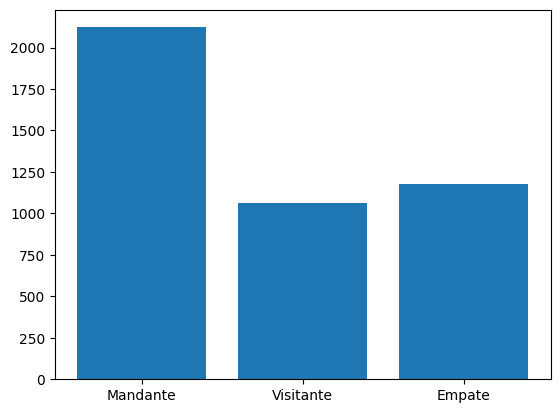

In [33]:
#Visualizando os dados por tipo de resultado

x = np.arange(3)
plt.bar(x, val)
plt.xticks(x, ('Mandante', 'Visitante', 'Empate'))
plt.show()

In [34]:
#Preparando os dados

#ordenando os dados dos jogos para manter a cronologia e treinar o modelo de
#forma correta

data = data.sort_values(by=['id_jogo'], ascending=True)
display(data)

#Deixar somente as variáveis numericas
num_data = data.drop(['Country','League','Season','Date','Time', 'Home', 'Away'],1)

display(num_data.head())

,Country,League,Season,Date,Time,id_jogo,Home,Away,HG,AG,...,PD,PA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA,home_id,away_id
0,Brazil,Serie A,2012,19/05/2012,22:30,0,Palmeiras,Portuguesa,1.0,1.0,...,3.86,5.25,1.76,3.87,5.31,1.69,3.50,4.90,312,50
1,Brazil,Serie A,2012,19/05/2012,22:30,1,Sport Recife,Flamengo RJ,1.0,1.0,...,3.39,2.68,2.83,3.42,2.70,2.59,3.23,2.58,1668,210
2,Brazil,Serie A,2012,20/05/2012,01:00,2,Figueirense,Nautico,2.0,1.0,...,4.04,6.72,1.67,4.05,7.22,1.59,3.67,5.64,935,170
3,Brazil,Serie A,2012,20/05/2012,20:00,3,Botafogo RJ,Sao Paulo,4.0,2.0,...,3.35,3.15,2.49,3.39,3.15,2.35,3.26,2.84,955,4035
4,Brazil,Serie A,2012,20/05/2012,20:00,4,Corinthians,Fluminense,0.0,1.0,...,3.53,4.41,1.96,3.53,4.41,1.89,3.33,3.89,2459,2376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4362,Brazil,Serie A,2023,13/08/2023,20:00,4362,Gremio,Fluminense,2.0,1.0,...,3.35,3.36,2.39,3.47,3.65,2.24,3.30,3.22,2316,2376
4363,Brazil,Serie A,2023,13/08/2023,22:30,4363,Flamengo RJ,Sao Paulo,1.0,1.0,...,3.73,4.87,1.81,3.82,5.10,1.77,3.63,4.56,210,4035
4364,Brazil,Serie A,2023,13/08/2023,22:30,4364,Fortaleza,Santos,4.0,0.0,...,3.98,7.47,1.57,4.10,8.00,1.52,3.84,7.02,3743,4071
4365,Brazil,Serie A,2023,14/08/2023,23:00,4365,Palmeiras,Cruzeiro,1.0,0.0,...,4.06,6.35,1.62,4.20,6.50,1.57,3.90,5.93,312,187


<ipython-input-34-b84eee4d312e>:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  num_data = data.drop(['Country','League','Season','Date','Time', 'Home', 'Away'],1)


,id_jogo,HG,AG,Res,PH,PD,PA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA,home_id,away_id
0,0,1.0,1.0,0.0,1.75,3.86,5.25,1.76,3.87,5.31,1.69,3.50,4.90,312,50
1,1,1.0,1.0,0.0,2.83,3.39,2.68,2.83,3.42,2.70,2.59,3.23,2.58,1668,210
2,2,2.0,1.0,1.0,1.60,4.04,6.72,1.67,4.05,7.22,1.59,3.67,5.64,935,170
3,3,4.0,2.0,1.0,2.49,3.35,3.15,2.49,3.39,3.15,2.35,3.26,2.84,955,4035
4,4,0.0,1.0,2.0,1.96,3.53,4.41,1.96,3.53,4.41,1.89,3.33,3.89,2459,2376


In [35]:
#separa as features
features = num_data.drop(['Res'],1)

#trata os valores NaN e confirma a eliminação dos mesmos
data = data.fillna(0)
num_data = num_data.fillna(0)
print (data.isnull().any())
print('=========')
print (num_data.isnull().any())

#separa as labels
labels = num_data['Res']

print('Features')
features = features.fillna(0)
print (features.head())

print ('=========')

print ('Labels')
print (labels.head())

Country    False
League     False
Season     False
Date       False
Time       False
id_jogo    False
Home       False
Away       False
HG         False
AG         False
Res        False
PH         False
PD         False
PA         False
MaxH       False
MaxD       False
MaxA       False
AvgH       False
AvgD       False
AvgA       False
home_id    False
away_id    False
dtype: bool
id_jogo    False
HG         False
AG         False
Res        False
PH         False
PD         False
PA         False
MaxH       False
MaxD       False
MaxA       False
AvgH       False
AvgD       False
AvgA       False
home_id    False
away_id    False
dtype: bool
Features
   id_jogo   HG   AG    PH    PD    PA  MaxH  MaxD  MaxA  AvgH  AvgD  AvgA  \
0        0  1.0  1.0  1.75  3.86  5.25  1.76  3.87  5.31  1.69  3.50  4.90   
1        1  1.0  1.0  2.83  3.39  2.68  2.83  3.42  2.70  2.59  3.23  2.58   
2        2  2.0  1.0  1.60  4.04  6.72  1.67  4.05  7.22  1.59  3.67  5.64   
3        3  4.0  2.0  2.49

<ipython-input-35-7c74f49aa97b>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  features = num_data.drop(['Res'],1)


In [36]:
#Escoolhendo as melhores features com Kbest

features_list = ('HG','AG','PH','PD','PA','MaxH','MaxD','MaxA','AvgH','AvgD','AvgA')

k_best_features = SelectKBest(k='all')
k_best_features.fit_transform(features, labels)
k_best_features_scores = k_best_features.scores_
raw_pairs = zip(features_list[1:], k_best_features_scores)
ordered_pairs = list(reversed(sorted(raw_pairs, key=lambda x: x[1])))

k_best_features_final = dict(ordered_pairs[:15])
best_features = k_best_features_final.keys()
print ('')
print ("Melhores features:")
print (k_best_features_final)


Melhores features:
{'PH': 1479.0256850578285, 'PD': 1379.9994583285177, 'PA': 185.42358147531195, 'AvgA': 181.1962421413288, 'MaxA': 164.68736300685768, 'MaxD': 162.33393790038843, 'AvgD': 159.7906106888019, 'AvgH': 81.54465515298689, 'MaxH': 79.12792237764229, 'AG': 2.030125078872671}


In [37]:
#separa as features com base nas melhores features para treinamento
features = num_data.drop(['Res','id_jogo','home_id','away_id', 'AG','PD','PH'],1)

#separa as labels para treinamento
labels = num_data['Res']

print('Features')
print (features.head())

print ('=========')

print ('Labels')
print (labels.head())

Features
    HG    PA  MaxH  MaxD  MaxA  AvgH  AvgD  AvgA
0  1.0  5.25  1.76  3.87  5.31  1.69  3.50  4.90
1  1.0  2.68  2.83  3.42  2.70  2.59  3.23  2.58
2  2.0  6.72  1.67  4.05  7.22  1.59  3.67  5.64
3  4.0  3.15  2.49  3.39  3.15  2.35  3.26  2.84
4  0.0  4.41  1.96  3.53  4.41  1.89  3.33  3.89
Labels
0    0.0
1    0.0
2    1.0
3    1.0
4    2.0
Name: Res, dtype: float64


<ipython-input-37-cab84b2f669d>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  features = num_data.drop(['Res','id_jogo','home_id','away_id', 'AG','PD','PH'],1)


In [38]:
# Normalizando os dados de entrada(features)

# Gerando o novo padrão
scaler = MinMaxScaler().fit(features)
features_scale = scaler.transform(features)

print ('Features: ',features_scale.shape)
print (features_scale)

Features:  (4367, 8)
[[0.16666667 0.17748479 0.02400573 ... 0.03235908 0.11913357 0.14746363]
 [0.16666667 0.09060176 0.06234325 ... 0.07933194 0.0866426  0.0562328 ]
 [0.33333333 0.22718053 0.02078108 ... 0.02713987 0.13959085 0.17656311]
 ...
 [0.66666667 0.2525355  0.01719814 ... 0.02348643 0.16004813 0.23082973]
 [0.16666667 0.21467208 0.01898961 ... 0.02609603 0.16726835 0.18796697]
 [0.16666667 0.21365788 0.02042279 ... 0.0276618  0.14921781 0.18757373]]


In [49]:
#Separa em treinamento e teste
#Separação manual para manter a ordem cronológica, uma vez que temos informação temporal.
#Treino linhas [:3831]
#Teste linhas [3832:3880]
#previsão linhas [3881:3911]


X_train = features_scale[:3831]
X_test = features_scale[3832:4179]
y_train = labels[:3831]
y_test = labels[3832:4179]

print( len(X_train), len(y_train))

print( len(X_test), len(y_test))

3831 3831
347 347


In [50]:
#Treinando e testando os modelos
print ('LogisticRegression')


clf_LR = LogisticRegression(multi_class='multinomial',max_iter=2000)
clf_LR.fit(X_train, y_train)
pred= clf_LR.predict(X_test)

lg_acc = accuracy_score(y_test, pred)
f1=f1_score(y_test,pred,average = 'micro')
print ('Acurácia LogisticRegression:{}'.format(lg_acc))
print ('F1 Score:{}'.format(f1) )

LogisticRegression
Acurácia LogisticRegression:0.6340057636887608
F1 Score:0.6340057636887608


In [51]:
#Testando LogistRegression hyper parameters

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }

search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid)

search.fit(X_train,y_train)
clf = search.best_estimator_
pred= clf.predict(X_test)
lg_acc = accuracy_score(y_test, pred)


f1=f1_score(y_test,pred,average = 'macro')

print ('Acurácia LogisticRegression:{}'.format(lg_acc))
print ('F1 Score:{}'.format(f1) )

print (clf)

Acurácia LogisticRegression:0.6282420749279539
F1 Score:0.5959603227816935
LogisticRegression(C=10, max_iter=1000)


In [52]:
#Treinando e testando os modelos
print ('SVC')


clf = SVC()
clf.fit(X_train, y_train)
pred= clf.predict(X_test)

svc_acc = accuracy_score(y_test, pred)
f1=f1_score(y_test,pred, average='micro')
print ('Acurácia SVC:{}'.format(svc_acc))
print ('F1 Score:{}'.format(f1) )

SVC
Acurácia SVC:0.6109510086455331
F1 Score:0.6109510086455331


In [53]:
#Testando SVC hyper parameters

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }

search = GridSearchCV(SVC(), param_grid)

search.fit(X_train,y_train)
clf_SVC = search.best_estimator_
pred= clf_SVC.predict(X_test)
acc = accuracy_score(y_test, pred)


f1=f1_score(y_test,pred,average = 'micro')

print ('F1 Score:{}'.format(f1))

print ('Acurácia LogisticRegression:{}'.format(acc))

print(clf_SVC)

F1 Score:0.6051873198847262
Acurácia LogisticRegression:0.6051873198847262
SVC(C=1000)


In [54]:
#Treinando e testando os modelos
print ('Decision Tree')


clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
pred= clf.predict(X_test)

dt_acc = accuracy_score(y_test, pred)
f1=f1_score(y_test,pred, average='macro')
print ('Acurácia Tree:{}'.format(dt_acc))
print ('F1 Score:{}'.format(f1) )


n_estimators = [10, 50, 100, 200]
max_depth = [3, 10, 20, 40]

Decision Tree
Acurácia Tree:0.5446685878962536
F1 Score:0.5136029411764705


In [55]:
#Testando Decision tree hyper parameters
print ('Decision Tree')

param_grid = {
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12]


}

search = GridSearchCV(DecisionTreeClassifier(), param_grid)

search.fit(X_train,y_train)
clf = search.best_estimator_
pred= clf.predict(X_test)
dt_acc = accuracy_score(y_test, pred)


f1=f1_score(y_test,pred,average = 'micro')

print ('Acurácia Decision Tree:{}'.format(dt_acc))
print ('F1 Score:{}'.format(f1) )

print (clf)

Decision Tree
Acurácia Decision Tree:0.5417867435158501
F1 Score:0.5417867435158501
DecisionTreeClassifier(max_depth=80, max_features=3, min_samples_leaf=4,
                       min_samples_split=12)


In [56]:
#Treinando e testando os modelos
print ('Naive baeys')


clf = GaussianNB()
clf.fit(X_train, y_train)
pred= clf.predict(X_test)

nb_acc = accuracy_score(y_test, pred)
f1=f1_score(y_test,pred, average='micro')
print ('Acurácia Naive baeys:{}'.format(nb_acc))
print ('F1 Score:{}'.format(f1) )

Naive baeys
Acurácia Naive baeys:0.5648414985590778
F1 Score:0.5648414985590778


In [58]:
#Executando a previsao e exibindo o resultado comparativo entre o
#resultado real e o previsto pelo modelo por jogos

previsao=features_scale[4180:]

game_id_full=data['id_jogo']
id_jogo=game_id_full[4180:]

res_full=data['Res']
res=res_full[4180:]

home_full=data['Home']
id_home=home_full[4180:]

away_full=data['Away']
id_away=away_full[4180:]


pred=clf_SVC.predict(previsao)

df=pd.DataFrame({'real': res, 'previsao':pred, 'jogo':id_jogo, 'mandante': id_home, 'visitante': id_away})

print(df)

      real  previsao  jogo      mandante   visitante
4180   2.0       2.0  4180    America MG  Fluminense
4181   1.0       1.0  4181     Palmeiras      Cuiaba
4182   1.0       1.0  4182  Athletico-PR       Goias
4183   1.0       1.0  4183   Botafogo RJ   Sao Paulo
4184   1.0       1.0  4184    Bragantino       Bahia
...    ...       ...   ...           ...         ...
4362   1.0       1.0  4362        Gremio  Fluminense
4363   0.0       0.0  4363   Flamengo RJ   Sao Paulo
4364   1.0       1.0  4364     Fortaleza      Santos
4365   1.0       1.0  4365     Palmeiras    Cruzeiro
4366   0.0       1.0  4366    Bragantino       Vasco

[187 rows x 5 columns]


<Axes: xlabel='previsao', ylabel='real'>

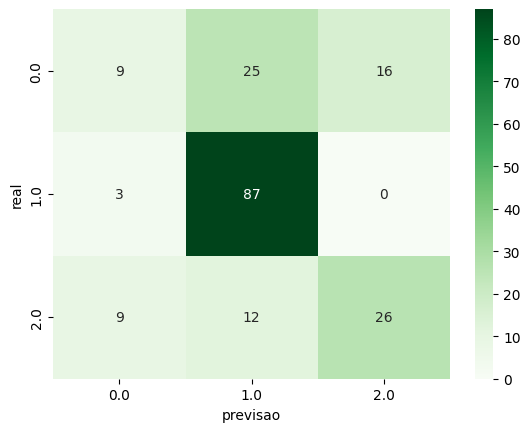

In [59]:
#confusion Matrix para analisarmos de forma objetivo o resultado

df=pd.DataFrame(df,columns=['real','previsao' ])

cf_matrix=pd.crosstab(df['real'], df['previsao'], rownames=['real'] , colnames=['previsao'])

sns.heatmap(cf_matrix, annot=True, cmap='Greens')